# Group Six Mixed Effects Random Forest Model
Chirag Lakhanpal, Amy Sharp, and James Crim!

# Setup

## General Settings, Import Packages

In [1]:
# code to change jupyter formatting
from IPython.core.display import display, HTML;
display(HTML("<style>.container { width:95% !important; }</style>"));

In [2]:
# package imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import wbgapi as wb
import statsmodels.api as sm
import seaborn as seas
import seaborn as sns
from scipy import stats

# merf
from merf.merf import MERF
from merf.viz import plot_merf_training_stats

# sklearn and subpackages
import sklearn as skl
from sklearn import model_selection as mdl_slct
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV

In [3]:
# supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [4]:
# plotting related imports
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

In [5]:
# set figure sizes
plt.rcParams['figure.figsize'] = (11,8)

## Data Prep

In [6]:
indexes = ['EN.ATM.CO2E.KT',        #CO2 emissions (kt)
           'NY.GDP.MKTP.PP.KD',     #GDP per capita, PPP (constant 2017 international $)
           'SP.POP.TOTL',           #Population, total 
           'EG.FEC.RNEW.ZS',        #Renewable energy consumption (% of total final energy
           'SP.URB.TOTL.IN.ZS',     #Urban population (% of total population) 
           'NV.MNF.TECH.ZS.UN',     #Medium and high-tech manufacturing value added (% manufacturing value added)
           'NE.TRD.GNFS.ZS']        #Trade (% of GDP)

In [7]:
# list of countries to investigate
countries = ['Argentina',
'Armenia',
'Australia',
'Austria',
'Belgium',
'Bulgaria',
'Belarus',
'Brazil',
'Canada',
'Switzerland',
'Chile',
'China',
'Colombia',
'Czech Republic',
'Germany',
'Denmark',
'Spain',
'Estonia',
'Finland',
'France',
'United Kingdom',
'Georgia',
'Greece',
'Croatia',
'Hungary',
'India',
'Ireland',
'Iceland',
'Israel',
'Italy',
'Japan',
'Kazakhstan',
'Korea, Rep.',
'Lithuania',
'Latvia',
'Moldova',
'Mexico',
'Malaysia',
'Netherlands',
'Norway',
'New Zealand',
'Panama',
'Peru',
'Poland',
'Portugal',
'Romania',
'Russian Federation',
'Singapore',
'Serbia',
'Slovak Republic',
'Slovenia',
'Sweden',
'Turkey',
'Ukraine',
'United States',
'South Africa'] 

In [8]:
countries = [wb.economy.coder(country) for country in countries]

In [9]:
raw_dataset = wb.data.DataFrame(series = indexes, economy = countries, time = range(1994,2023), labels=True,columns='series')

In [10]:
raw_dataset.unstack(0).stack()

Country  Time  EG.FEC.RNEW.ZS  EN.ATM.CO2E.KT  \
time   economy                                                        
YR2021 ZAF       South Africa  2021             NaN             NaN   
       USA      United States  2021             NaN             NaN   
       UKR            Ukraine  2021             NaN             NaN   
       TUR            Turkiye  2021             NaN             NaN   
       SWE             Sweden  2021             NaN             NaN   
...                       ...   ...             ...             ...   
YR1994 BEL            Belgium  1994        0.939573        114900.0   
       AUT            Austria  1994       25.679455         58280.0   
       AUS          Australia  1994        8.259947        280180.0   
       ARM            Armenia  1994       17.763653          2740.0   
       ARG          Argentina  1994       10.734909        111910.0   

                NE.TRD.GNFS.ZS  NV.MNF.TECH.ZS.UN  NY.GDP.MKTP.PP.KD  \
time   economy                                                         
YR2021 ZAF           56.071227                NaN       7.881121e+11   
       USA                 NaN                NaN       2.093228e+13   
       UKR           82.621300                NaN       5.355789e+11   
       TUR           71.212724                NaN       2.657762e+12   
       SWE           88.162017                NaN       5.525622e+11   
...                        ...                ...                ...   
YR1994 BEL          113.232300          14.080100       3.740897e+11   
       AUT           65.987093          36.610757       3.129625e+11   
       AUS           36.458731          27.756124       5.726639e+11   
       ARM          112.429365          28.824233       9.053823e+09   
       ARG           18.134346          29.628354       6.224138e+11   

                SP.POP.TOTL  SP.URB.TOTL.IN.ZS  
time   economy                                  
YR2021 ZAF       60041996.0             67.847  
       USA      331893745.0             82.873  
       UKR       43814581.0             69.757  
       TUR       85042736.0             76.569  
       SWE       10415811.0             88.238  
...                     ...                ...  
YR1994 BEL       10115603.0             96.700  
       AUT        7936118.0             61.870  
       AUS       17855000.0             85.028  
       ARM        3283664.0             66.332  
       ARG       34402669.0             87.960  

[1568 rows x 9 columns]

# Overview

## Get Data Overview

In [11]:
# create function to get an overview of some base descriptive statistics
def get_data_overview(raw_dataset):
    col = ['Number of variables',
    'Number of observations',
    'Missing cells',
    'Missing cells (%)',
    'Rows with Missing cells',
    'Rows with Missing cells (%)',
    'Duplicate rows',
    'Duplicate rows (%)']

    val = [len(raw_dataset.columns),
    len(raw_dataset),
    raw_dataset.isna().values.sum(),
    (raw_dataset.isna().values.sum()/len(raw_dataset)) * 100,
    len(raw_dataset) - len(raw_dataset.dropna()),
    ((len(raw_dataset)-len(raw_dataset.dropna()))/len(raw_dataset)) * 100,
    raw_dataset.duplicated().sum(),
    raw_dataset.duplicated().sum()]

    val = list(map(round,val))

    return pd.DataFrame(zip(col,val), columns=['Variables', 'Count'])

# use overview function
overview = get_data_overview(raw_dataset)
overview

,Variables,Count
0,Number of variables,9
1,Number of observations,1568
2,Missing cells,362
3,Missing cells (%),23
4,Rows with Missing cells,125
5,Rows with Missing cells (%),8
6,Duplicate rows,0
7,Duplicate rows (%),0


In [12]:
overview

,Variables,Count
0,Number of variables,9
1,Number of observations,1568
2,Missing cells,362
3,Missing cells (%),23
4,Rows with Missing cells,125
5,Rows with Missing cells (%),8
6,Duplicate rows,0
7,Duplicate rows (%),0


## Data preprocessing

### Renaming columns for berter readability

In [13]:
# renaming the columns to make them more comprehensible
raw_dataset = raw_dataset.rename({'EG.FEC.RNEW.ZS': 'Renewable energy consumption',
'EN.ATM.CO2E.KT': 'CO2 emissions',
'NE.TRD.GNFS.ZS': 'Trade (% of GDP)',
'NV.MNF.TECH.ZS.UN': 'Perc Manufacturing Value Added',
'NY.GDP.MKTP.PP.KD': 'GDP per capita',
'SP.POP.TOTL': 'Total Population',
'SP.URB.TOTL.IN.ZS': 'Urban Population',
},axis = 1)

In [14]:
raw_dataset.head()

Country  Time  Renewable energy consumption  \
economy time                                                       
ZAF     YR2021  South Africa  2021                           NaN   
        YR2020  South Africa  2020                           NaN   
        YR2019  South Africa  2019                         10.50   
        YR2018  South Africa  2018                         10.19   
        YR2017  South Africa  2017                         10.45   

                CO2 emissions  Trade (% of GDP)  \
economy time                                      
ZAF     YR2021            NaN         56.071227   
        YR2020            NaN         51.126846   
        YR2019  439640.014648         54.150246   
        YR2018  434350.006104         54.507584   
        YR2017  435649.993896         53.535932   

                Perc Manufacturing Value Added  GDP per capita  \
economy time                                                     
ZAF     YR2021                             NaN    7.881121e+11   
        YR2020                             NaN    7.511939e+11   
        YR2019                       24.428034    8.028319e+11   
        YR2018                       24.428034    8.019253e+11   
        YR2017                       24.428034    7.901706e+11   

                Total Population  Urban Population  
economy time                                        
ZAF     YR2021        60041996.0            67.847  
        YR2020        59308690.0            67.354  
        YR2019        58558267.0            66.856  
        YR2018        57792520.0            66.355  
        YR2017        57009751.0            65.850

### Missing value check


In [15]:
# check for missing values in datasets
raw_dataset.isna().sum()

Country                             0
Time                                0
Renewable energy consumption      112
CO2 emissions                     112
Trade (% of GDP)                   14
Perc Manufacturing Value Added    112
GDP per capita                     12
Total Population                    0
Urban Population                    0
dtype: int64

In [16]:
# remove missing values from the dataset
raw_dataset = raw_dataset.dropna()

### Outlier detection and treatment

In [17]:
def outlier_treatment(dataset):
    # outliers more than three sds away are replaced with the mean value of the column
    outlier_summary = []

    for col in dataset.columns[2:]:
        outliers = dataset[(np.abs(stats.zscore(dataset[col]))>3)][col]
        outlier_summary.append([col, len(outliers)])
        dataset.loc[outliers.index, col] = dataset[col].mean()

    outlier_summary = pd.DataFrame(outlier_summary, columns=['Variables', 'No. of Outliers'])

    return dataset, outlier_summary

# run function
raw_dataset_no_outliers = raw_dataset.copy()
raw_dataset_no_outliers, outlier_summary = outlier_treatment(raw_dataset_no_outliers)

outlier_summary

,Variables,No. of Outliers
0,Renewable energy consumption,14
1,CO2 emissions,43
2,Trade (% of GDP),27
3,Perc Manufacturing Value Added,10
4,GDP per capita,38
5,Total Population,52
6,Urban Population,10


### Calculating Column of Intrest

In [18]:
raw_dataset['CO2 per Capita'] = raw_dataset['CO2 emissions']/raw_dataset['Total Population']

### Side-by-Side Plots

In [19]:
def groupby_by_predictor_plot(ax, groupby_name, predictor_name):
    
    # set outcome variable name
    outcome_name = 'CO2 per Capita'
    
    # get list of years
    year_list_strings = np.array(range(1994, 2020)).astype(str)
    
    # set labels
    ax.set_title(groupby_name)
    ax.set_xlabel(predictor_name)
    ax.set_ylabel(outcome_name)
    
    # make scatterplot between set predictor and outcome variables for country or year
    dat2plot = raw_dataset.groupby(groupby_name).mean()
    x2plot = dat2plot[predictor_name]
    y2plot = dat2plot[outcome_name]
    ax.scatter(x2plot, y2plot)
    
    # get list of text labels
    txt2plot = []
    if groupby_name == 'Country':
        txt2plot = countries
    elif groupby_name == 'Time':
        txt2plot = year_list_strings
    
    # add text labels
    for i, txt in enumerate(txt2plot):
        ax.annotate(txt, (x2plot[i], y2plot[i]))

In [20]:
def side_by_side_plot(predictor_name):
    
    # create figure and title
    fig, axs = plt.subplots(1, 2);
    fig.suptitle(predictor_name);
    
    # create plots for country and year respectively
    groupby_by_predictor_plot(ax=axs[0], groupby_name='Country', predictor_name=predictor_name)
    groupby_by_predictor_plot(ax=axs[1], groupby_name='Time', predictor_name=predictor_name)

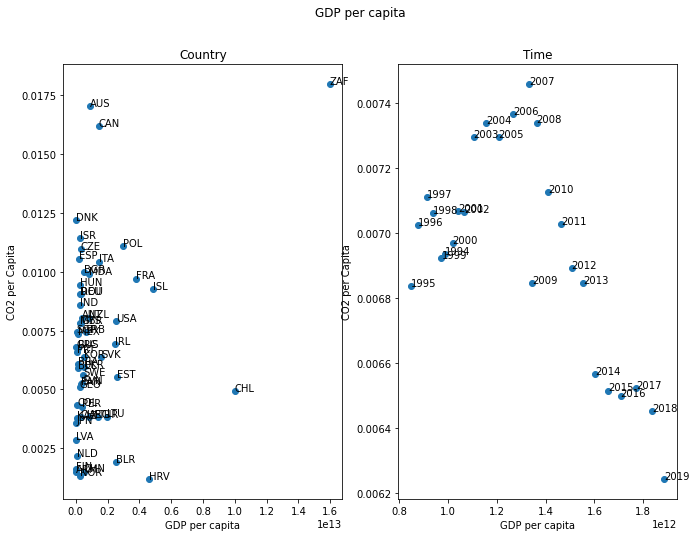

In [21]:
# plot the scatterplot of predicters against the outcome variable averaged across countries and years. Each point is labeled.
# Note that while many of the labels, particularly for countries, are overlapping and difficult to read, the outliers are easy to
# discern which is most important for this step of the project.
side_by_side_plot('GDP per capita')

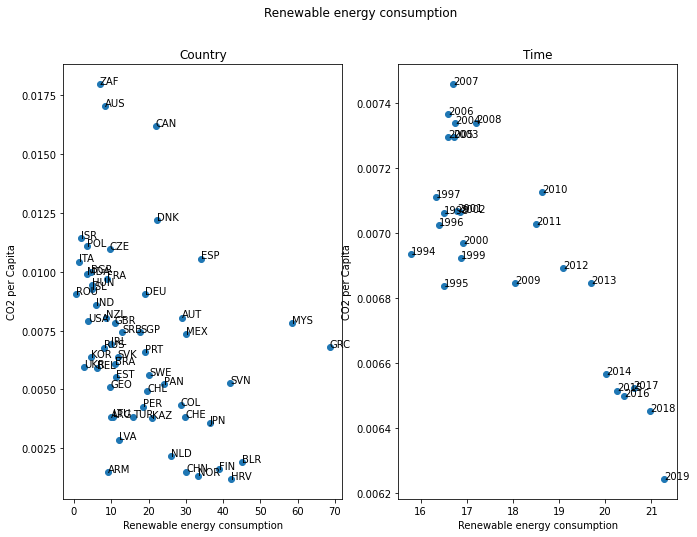

In [22]:
side_by_side_plot('Renewable energy consumption')

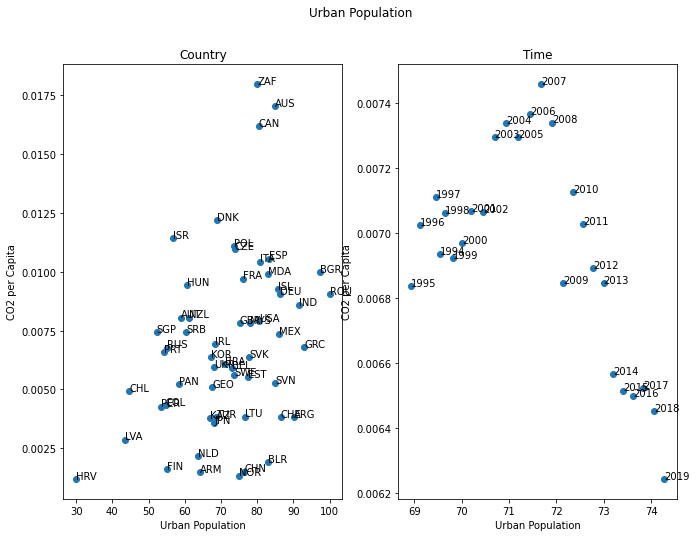

In [23]:
side_by_side_plot('Urban Population')

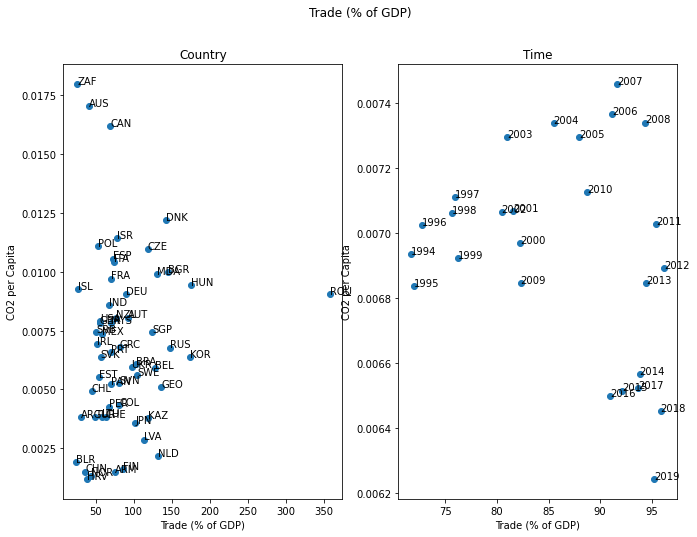

In [24]:
side_by_side_plot('Trade (% of GDP)')

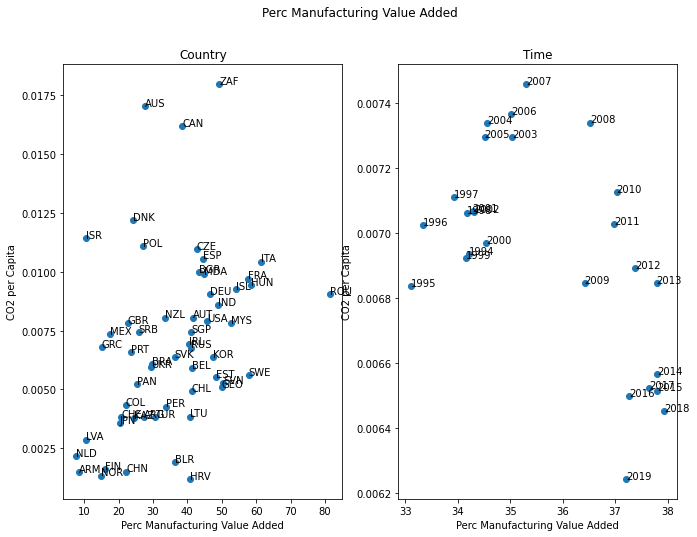

In [25]:
side_by_side_plot('Perc Manufacturing Value Added')

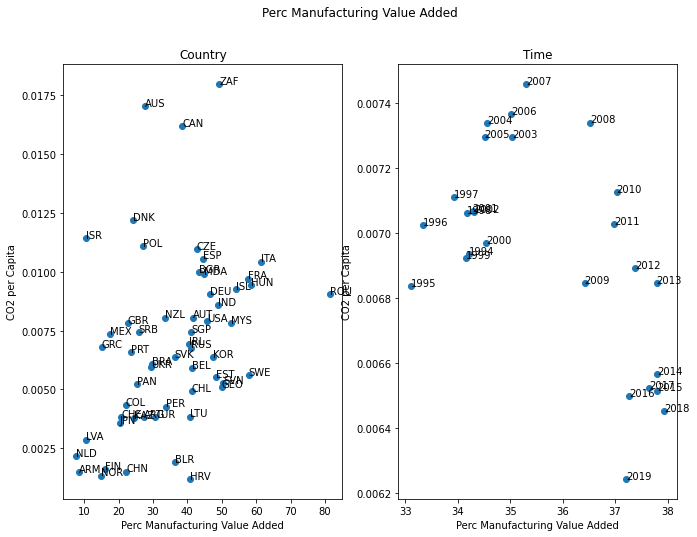

In [26]:
side_by_side_plot('Perc Manufacturing Value Added')

### Log Trasforming the data

In [28]:
# log base 10 transform the data
processed_df = raw_dataset_no_outliers.copy()
for col in [col for col in processed_df.columns[2:]]:
    processed_df[col] = np.log10(processed_df[col] + 1)

In [29]:
processed_df = raw_dataset.copy()

## Exploratory Data Analysis

### Data Summary


In [30]:
processed_df.describe(include='all')

,Country,Time,Renewable energy consumption,CO2 emissions,Trade (% of GDP),Perc Manufacturing Value Added,GDP per capita,Total Population,Urban Population,CO2 per Capita
count,1443,1443,1443.000000,1.443000e+03,1443.000000,1443.000000,1.443000e+03,1.443000e+03,1443.000000,1443.000000
unique,56,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Finland,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,26,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,17.982641,4.307898e+05,86.239594,35.716637,1.304783e+12,7.806968e+07,71.568561,0.006947
std,NaN,NaN,15.283680,1.195953e+06,54.590937,15.946366,2.768642e+12,2.317357e+08,14.292121,0.003848
min,NaN,NaN,0.330000,1.630000e+03,13.388233,3.904432,9.004634e+09,2.674680e+05,26.399000,0.000725
25%,NaN,NaN,6.375000,3.829000e+04,53.191604,24.411546,1.514772e+11,5.264671e+06,61.586500,0.004079
50%,NaN,NaN,13.090000,6.970000e+04,72.481643,36.388831,3.734972e+11,1.086213e+07,73.504000,0.006603
75%,NaN,NaN,27.240000,3.353500e+05,105.398553,46.596252,1.222087e+12,4.741090e+07,81.508500,0.009026


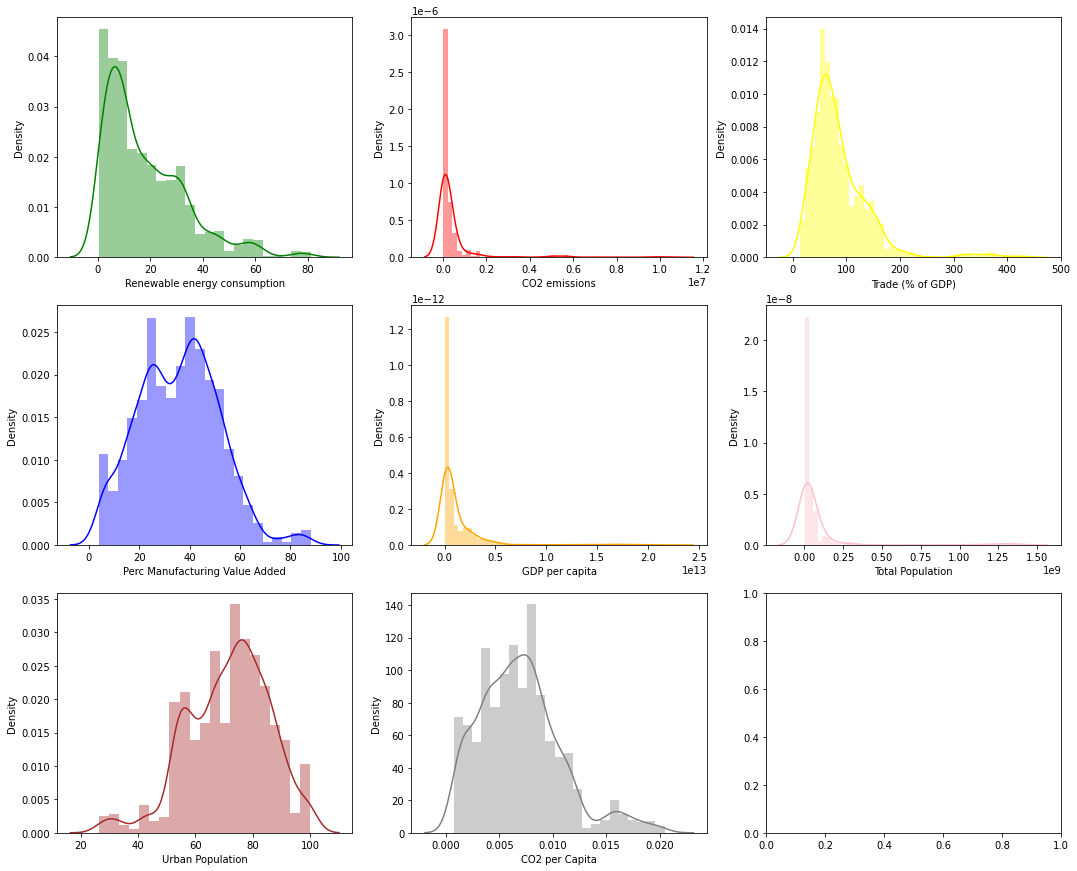

In [31]:
# plot histograms of all six variables with smoothed approximate distribution
%matplotlib inline

n_rows=3
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (18,15))

colors = {0:'green',1:'red',2:'yellow',3:'blue',4:'orange',5:'pink',6:'brown',7:'gray'}

for i, column in enumerate(processed_df.columns[2:]):
     seas.distplot(processed_df[column],color= colors[i],ax=axes[i//n_cols,i%n_cols])

### Pair Plots

In [ ]:
# create pair plots to investigate relations between data, focusing on countries
seas.pairplot(data=processed_df, hue='Country', palette="Set1")

In [63]:
# create pair plots to investigate relations between data, focusing on years
seas.pairplot(data=processed_df, hue='Time', palette="Set1")

### Box Plots

In [64]:
# create box plots to further investigate data and their distributions
from plotly.subplots import make_subplots
import plotly.graph_objects as go

n_rows=3
n_cols=3

vars = ['Renewable energy consumption', 'CO2 emissions',
       'Trade (% of GDP)', 'Perc Manufacturing Value Added', 'GDP per capita',
       'Total Population', 'Urban Population', 'CO2 per Capita']

figsize = (18,15)

fig = make_subplots(rows=n_rows, cols=n_cols)

fig.update_layout(template="plotly_dark",width=1400,
    height=1000)

for i, var in enumerate(vars):
    
    fig.add_trace(
        go.Box(y=processed_df[var],
        name=var),
        row=(i//n_cols)+1, col=(i%n_cols)+1,
    )

fig.update_traces(boxpoints='all', jitter=.3)


## Modeling

### Mixed Effects Random Forest model.  - `y=f(X)+biZ+e`

* y is the target variable. The current code only supports regression for now, e.g. continuously varying scalar value
* X is the fixed effect features. Assume p dimensional
* f(.) is the nonlinear fixed effects mode, e.g. random forest
* Z is the random effect features. Assume q dimensional.
* e is iid noise ~N(0, sigma_e²)
* i is the cluster index. Assume k clusters in the training.
* bi is the random effect coefficients. They are different per cluster i but are assumed to be drawn from the same distribution ~N(0, Sigma_b) where Sigma_b is learned from the data.

### MERF Package

**Parameters**

* X (np.ndarray) – fixed effect covariates
* Z (np.ndarray) – random effect covariates
* clusters (pd.Series) – cluster assignments for samples
* y (np.ndarray) – response/target variable

A lot of data out there has a clustered structure. The most typical example is longitudinal clustering, which occurs when there are many measurements per individual of a phenomenon to be modeled. Assume we wish to model math test scores as a function of sleep parameters, but each student has many measures. The unique student in this situation is a cluster. We employed the MERF model for this project to predict the CO2 per capita values, clustering the 56 countries we have.

## Evaluation Meterics

## 4.2 Evaluation Metrics

*From Wikipedia*

1. **Mean Absolute Percentage Error (MAPE)**

The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics. It usually expresses the accuracy as a ratio defined by the formula:

2. **Model Accuracy**

As previously stated, the MAPE number provides the percentage of errors. By subtracting that percentage from 100%, we can determine how accurate our model actually is.

1. **Mean squared error**

In statistics, the mean squared error or mean squared deviation of an estimator measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.


## Data Spliting

In [65]:
# plot data into testing and training sets, where 80% of the data is for training
X = processed_df[['Renewable energy consumption','Trade (% of GDP)','Perc Manufacturing Value Added','GDP per capita','Urban Population']]
y = processed_df['CO2 per Capita']
  
# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)


## Hyperparameter Tuning

### We will use 2 techniques for hyperparameter tuning - Random Search and Gird Search. In grid search, we define the combinations and do training of the model, whereas in RandomizedSearchCV the model selects the combinations randomly.

In [66]:
# create a function to get the output measures of a model on the test data. We will compare these measures to determine the best model hyperparameters
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    mse = np.sqrt(np.sum((y_test - predictions)**2)) / len(y_test)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy: {:0.2f}%.'.format(accuracy))
    print('Mean Squared Error: {:0.6f}'.format(np.mean(mse)))
    print('Mean Absolute Percentage Error (MAPE): {:0.2f}'.format(mape))

    return np.mean(errors), accuracy, mape, np.mean(mse)

### Random Forest (Base Model) 

In [67]:
# this is the most basic model that will serve as a baseline comparison
base_rf_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_rf_model.fit(X_train, y_train)
base_rf_errors, base_rf_accuracy, base_rf_mape, base_rf_mse = evaluate(base_rf_model, X_test, y_test)

Model Performance
Average Error: 0.0003 degrees.
Accuracy: 87.94%.
Mean Squared Error: 0.000030
Mean Absolute Percentage Error (MAPE): 12.06


### RandomizedSearchCV 

In [68]:
# try a random search approach to finding the best model parameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # <- Number of trees in random forest
max_features = ['auto', 'sqrt'] # <- Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # <-  Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # <- Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # <- Minimum number of samples required at each leaf node
bootstrap = [True, False] # <- Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Combinations to try for Hyperparameter Tuning

In [72]:
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [73]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### Random Search Best Parameters

#### Mean cross-validated score of the best estimator

In [74]:
# print out the best score!
print('The best score is : {}%'.format(round(rf_random.best_score_*100.0, 2)))

The best score is : 90.99%


In [75]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

#### Best Random Search Model Evaluation

In [79]:
# show the overall model performance of the best random search model
best_random = rf_random.best_estimator_
random_rf_errors,random_rf_accuracy,random_rf_mape,random_rf_mse = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.0003 degrees.
Accuracy: 89.53%.
Mean Squared Error: 0.000025
Mean Absolute Percentage Error (MAPE): 10.47


### GridSearchCV

In [80]:
# Create the parameter grid based on the results of random search 
param_grid = {
      'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, None],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [600, 800, 1000, 1200, 1400]
    }

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)

In [81]:
# apply grid search method to finding best hyperparameters
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1001 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1446 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 20.2min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [80, 90, 100, 110, None],
                         'max_features': [2, 3], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [600, 800, 1000, 1200, 1400]},
             return_train_score=True, verbose=2)

### Gird Search Best Parameters

#### Mean cross-validated score of the best estimator

In [82]:
# print best grid search model score!
print('The best score is : {}%'.format(round(grid_search.best_score_*100.0, 2)))

The best score is : 90.96%


In [83]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

#### Best Grid Search Model Evaluation

In [84]:
# show the associated model parameters of the best grid search
best_grid = grid_search.best_estimator_
grid_rf_errors,grid_rf_accuracy,grid_rf_mape,grid_rf_mse = evaluate(best_grid, X_test, y_test) 

Model Performance
Average Error: 0.0003 degrees.
Accuracy: 88.07%.
Mean Squared Error: 0.000028
Mean Absolute Percentage Error (MAPE): 11.93


# Mixed Effects Random Forest

## Predictor variable Random Effect
Try using the predictors as all random effects, and compare with further down where we use them as fixed effects

### Base Model

In [87]:
# run the base model to compare with the other approaches
cv = KFold(n_splits=5, shuffle=True)
mse_base_re_mrf = []
mape_base_re_mrf = []
error_base_re_mrf = []
accuracy_base_re_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as RE
    base_re_mrf = MERF()
    X_train =  train[['Time']]
    Z_train = np.array((np.ones(len(X_train)), train['Renewable energy consumption'], 
                                               train['Trade (% of GDP)'],
                                               train['Perc Manufacturing Value Added'],
                                               train['GDP per capita'],
                                               train['Urban Population'])).T
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    base_re_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as RE
    X_test =  test[['Time']]
    Z_test = np.array((np.ones(len(X_test)),test['Renewable energy consumption'], 
                                               test['Trade (% of GDP)'],
                                               test['Perc Manufacturing Value Added'],
                                               test['GDP per capita'],
                                               test['Urban Population'])).T
    clusters_test = test['Country']
    yhat_mrf = base_re_mrf.predict(X_test, Z_test, clusters_test)
    mse_base_re_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_base_re_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_base_re_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_base_re_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_base_re_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_base_re_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_base_re_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_base_re_mrf)))

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 93.73%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 6.27%


<AxesSubplot:>

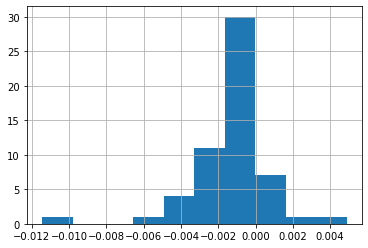

In [88]:
base_re_mrf.b_hat_history[-1][1].hist()

### Model - MERF with the Best Random Search Parameter 

In [89]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [90]:
# run the model with the best parameters as given by the random search approach
cv = KFold(n_splits=5, shuffle=True)
mse_random_re_mrf = []
mape_random_re_mrf = []
error_random_re_mrf = []
accuracy_random_re_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as RE
    random_re_mrf = MERF(fixed_effects_model=RandomForestRegressor(n_estimators=800,
                                                             min_samples_split= 2,
                                                             min_samples_leaf= 1,
                                                             max_features= 'auto',
                                                             max_depth= 100,
                                                             bootstrap= True))
    X_train =  train[['Time']]
    Z_train = np.array((np.ones(len(X_train)), train['Renewable energy consumption'], 
                                               train['Trade (% of GDP)'],
                                               train['Perc Manufacturing Value Added'],
                                               train['GDP per capita'],
                                               train['Urban Population'])).T
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    random_re_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as RE
    X_test =  test[['Time']]
    Z_test = np.array((np.ones(len(X_test)),test['Renewable energy consumption'], 
                                               test['Trade (% of GDP)'],
                                               test['Perc Manufacturing Value Added'],
                                               test['GDP per capita'],
                                               test['Urban Population'])).T
    clusters_test = test['Country']
    yhat_mrf = random_re_mrf.predict(X_test, Z_test, clusters_test)
    mse_random_re_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_random_re_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_random_re_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_random_re_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_random_re_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_random_re_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_random_re_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_random_re_mrf)))

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 98.91%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 1.09%


<AxesSubplot:>

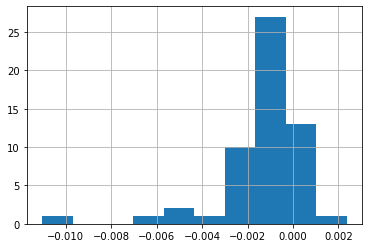

In [91]:
random_re_mrf.b_hat_history[-1][1].hist()

### Model - MERF with the Best Grid Search Parameter 

In [92]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [94]:
# run the model with the best parameters as given by the grid search approach
cv = KFold(n_splits=5, shuffle=True)
mse_grid_re_mrf = []
mape_grid_re_mrf = []
error_grid_re_mrf = []
accuracy_grid_re_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as RE
    grid_re_mrf = MERF(fixed_effects_model=RandomForestRegressor(n_estimators=1000,
                                                             min_samples_split= 2,
                                                             min_samples_leaf= 1,
                                                             max_features= 3,
                                                             max_depth= 80,
                                                             bootstrap= True))
    X_train =  train[['Time']]
    Z_train = np.array((np.ones(len(X_train)), train['Renewable energy consumption'], 
                                               train['Trade (% of GDP)'],
                                               train['Perc Manufacturing Value Added'],
                                               train['GDP per capita'],
                                               train['Urban Population'])).T
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    grid_re_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as RE
    X_test =  test[['Time']]
    Z_test = np.array((np.ones(len(X_test)),test['Renewable energy consumption'], 
                                               test['Trade (% of GDP)'],
                                               test['Perc Manufacturing Value Added'],
                                               test['GDP per capita'],
                                               test['Urban Population'])).T
    clusters_test = test['Country']
    yhat_mrf = grid_re_mrf.predict(X_test, Z_test, clusters_test)
    mse_grid_re_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_grid_re_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_grid_re_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_grid_re_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_grid_re_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_grid_re_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_grid_re_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_grid_re_mrf)))

ValueError: max_features must be in (0, n_features]

<AxesSubplot:>

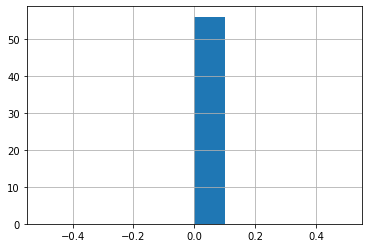

In [95]:
grid_re_mrf.b_hat_history[-1][1].hist()

## Predictor variable as Fixed Effect
Run the same model but using the predictors as fixed effects

### Base Model

In [96]:
# run the model with the base parameters as a comparison baseline
cv = KFold(n_splits=5, shuffle=True)
mse_base_fe_mrf = []
mape_base_fe_mrf = []
error_base_fe_mrf = []
accuracy_base_fe_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as FE
    base_fe_mrf = MERF()
    X_train =  train[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    base_fe_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as FE
    X_test =  test[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['Country']
    yhat_mrf = base_fe_mrf.predict(X_test, Z_test, clusters_test)
    mse_base_fe_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_base_fe_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_base_fe_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_base_fe_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_base_fe_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_base_fe_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_base_fe_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_base_fe_mrf)))

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 93.50%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 6.50%


<AxesSubplot:>

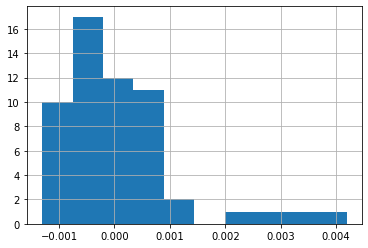

In [98]:
base_fe_mrf.b_hat_history[-1][0].hist()

### Model - MERF with the Best Random Search Parameter 

In [99]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [100]:
# run the model with the best parameters as given by the random search approach
cv = KFold(n_splits=5, shuffle=True)
mse_random_fe_mrf = []
mape_random_fe_mrf = []
error_random_fe_mrf = []
accuracy_random_fe_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as FE
    random_fe_mrf = MERF(fixed_effects_model=RandomForestRegressor(n_estimators=800,
                                                             min_samples_split= 2,
                                                             min_samples_leaf= 1,
                                                             max_features= 'auto',
                                                             max_depth= 100,
                                                             bootstrap= True))
    X_train =  train[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    random_fe_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as FE
    X_test =  test[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['Country']
    yhat_mrf = random_fe_mrf.predict(X_test, Z_test, clusters_test)
    mse_random_fe_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_random_fe_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_random_fe_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_random_fe_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_random_fe_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_random_fe_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_random_fe_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_random_fe_mrf)))

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 94.03%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 5.97%


In [101]:
base_fe_mrf

### Model - MERF with the Best Grid Search Parameter 

In [102]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [103]:
# run the model with the best parameters as given by the random grid approach
cv = KFold(n_splits=5, shuffle=True)
mse_grid_fe_mrf = []
mape_grid_fe_mrf = []
error_grid_fe_mrf = []
accuracy_grid_fe_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as FE
    grid_fe_mrf = MERF(fixed_effects_model=RandomForestRegressor(n_estimators=1000,
                                                             min_samples_split= 2,
                                                             min_samples_leaf= 1,
                                                             max_features= 3,
                                                             max_depth= 80,
                                                             bootstrap= True))
    X_train =  train[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    grid_fe_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as FE
    X_test =  test[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['Country']
    yhat_mrf = grid_fe_mrf.predict(X_test, Z_test, clusters_test)
    mse_grid_fe_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_grid_fe_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_grid_fe_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_grid_fe_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_grid_fe_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_grid_fe_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_grid_fe_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_grid_fe_mrf)))

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 94.18%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 5.82%


### Model Evaluation Metrics Summary

In [104]:
# Now! We compare the metrics of all the models we ran to determine the best one!
data = [['Random Forest (Base Model)', base_rf_errors,base_rf_accuracy,base_rf_mse,base_rf_mape],
['Random Forest (Best Random Search Model)',random_rf_errors,random_rf_accuracy,random_rf_mse,random_rf_mape],
['Random Forest (Best Grid Search Model)',grid_rf_errors,grid_rf_accuracy,grid_rf_mse,grid_rf_mape],
['MERF with Predictor Variable as RE (Base Model)', round(np.mean(np.mean([np.mean(error_set) for error_set in error_base_re_mrf])),6),round(np.mean(accuracy_base_re_mrf),1),round(np.mean(mse_base_re_mrf),6),round(np.mean(mape_base_re_mrf),2)],
['MERF with Predictor Variable as RE (Best Random Search Model)',round(np.mean(np.mean([np.mean(error_set) for error_set in error_random_re_mrf])),6),round(np.mean(accuracy_random_re_mrf),2),round(np.mean(mse_random_re_mrf),6),round(np.mean(mape_random_re_mrf),2)],
['MERF with Predictor Variable as RE (Best Grid Search Model)',round(np.mean(np.mean([np.mean(error_set) for error_set in error_grid_re_mrf])),6),round(np.mean(accuracy_grid_re_mrf),2),round(np.mean(mse_grid_re_mrf),6),round(np.mean(mape_grid_re_mrf),2)],
['MERF with Predictor Variable as FE (Base Model)', round(np.mean(np.mean([np.mean(error_set) for error_set in error_base_fe_mrf])),6),round(np.mean(accuracy_base_fe_mrf),2),round(np.mean(mse_base_fe_mrf),6),round(np.mean(mape_base_fe_mrf),2)],
['MERF with Predictor Variable as FE (Best Random Search Model)',round(np.mean(np.mean([np.mean(error_set) for error_set in error_random_fe_mrf])),6),round(np.mean(accuracy_random_fe_mrf),2),round(np.mean(mse_random_fe_mrf),6),round(np.mean(mape_random_fe_mrf),2)],
['MERF with Predictor Variable as FE (Best Grid Search Model)',round(np.mean(np.mean([np.mean(error_set) for error_set in error_grid_fe_mrf])),6),round(np.mean(accuracy_grid_fe_mrf),2),round(np.mean(mse_grid_fe_mrf),6),round(np.mean(mape_grid_fe_mrf),2)]]

In [105]:
# put the results from the output crunching in a dataframe
results = pd.DataFrame(data = data, columns=['Model',
                                'Average Error',
                                'Accuracy', 
                                'Mean Squared Error (MSE)',
                                'Mean Absolute Percentage Error (MAPE)'])

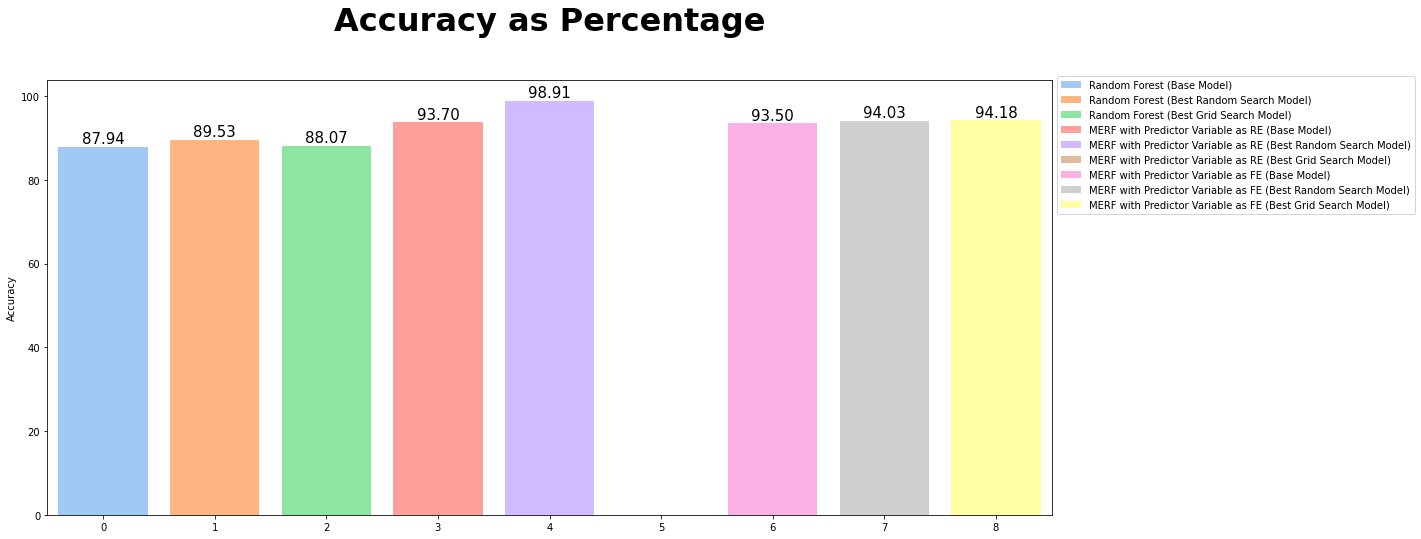

In [108]:
# plot the different models' accuracy to compare them
plt.figure(figsize=(18,8))
ax = sns.barplot(x = results.index, y = 'Accuracy', data = results,hue = 'Model',
            palette = 'pastel',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,  
            ci = 'sd',
            dodge = False
            )

ax.legend(bbox_to_anchor=(1, 1.02))
ax.set_title("Accuracy as Percentage",fontdict= { 'fontsize': 32,'fontweight':'bold'}, y = 1.1)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


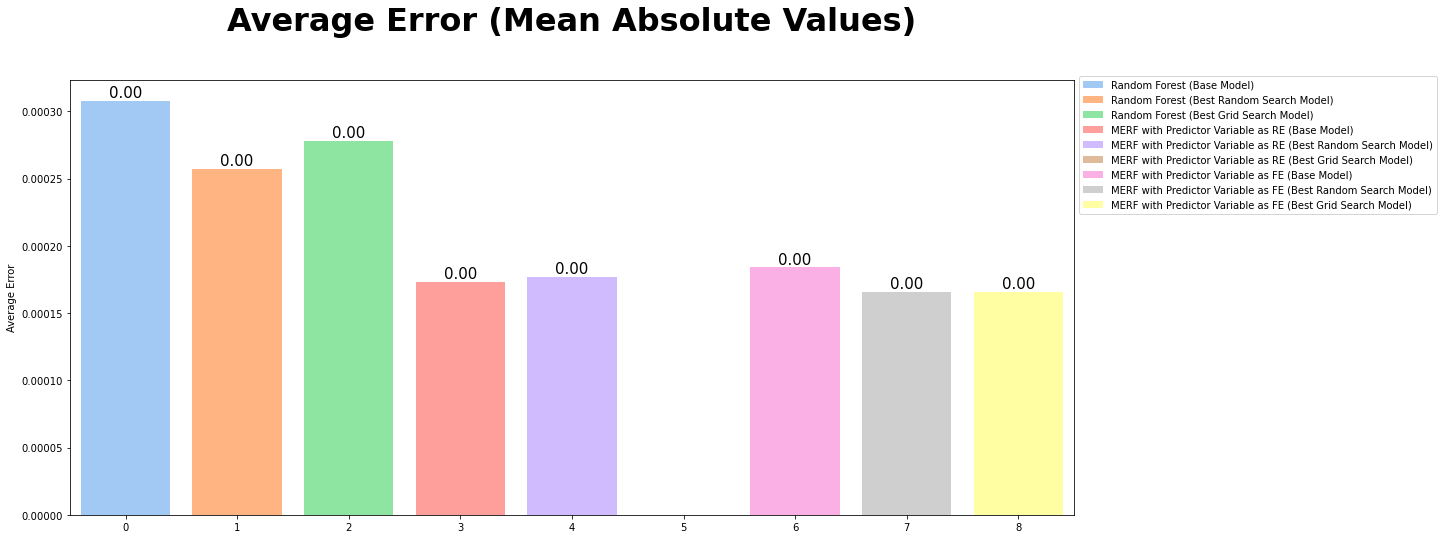

In [109]:
# plot the different models' mean absolute value to compare them
plt.figure(figsize=(18,8))
ax = sns.barplot(x = results.index, y = 'Average Error', data = results,hue = 'Model',
            palette = 'pastel',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,  
            ci = 'sd',
            dodge = False
            )

ax.legend(bbox_to_anchor=(1, 1.02))
ax.set_title("Average Error (Mean Absolute Values)",fontdict= { 'fontsize': 32,'fontweight':'bold'}, y = 1.1)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


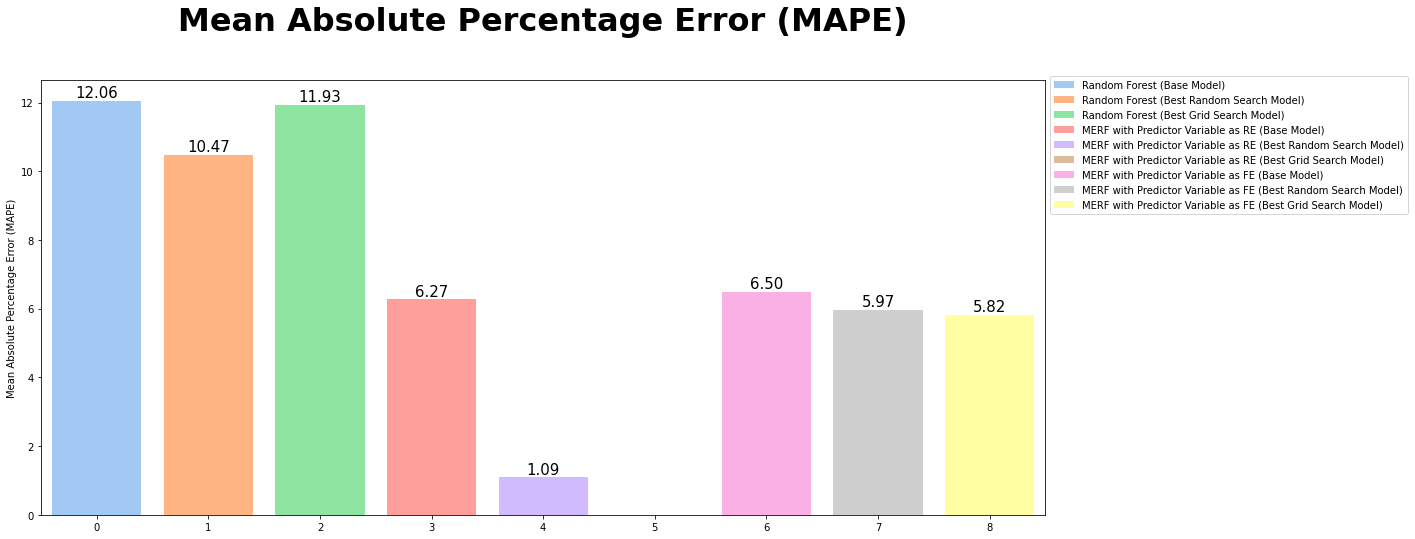

In [110]:
# plot the different models' MAPE to compare them
plt.figure(figsize=(18,8))
ax = sns.barplot(x = results.index, y = 'Mean Absolute Percentage Error (MAPE)', data = results,hue = 'Model',
            palette = 'pastel',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,  
            ci = 'sd',
            dodge = False
            )

ax.legend(bbox_to_anchor=(1, 1.02))
ax.set_title("Mean Absolute Percentage Error (MAPE)",fontdict= { 'fontsize': 32,'fontweight':'bold'}, y = 1.1)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


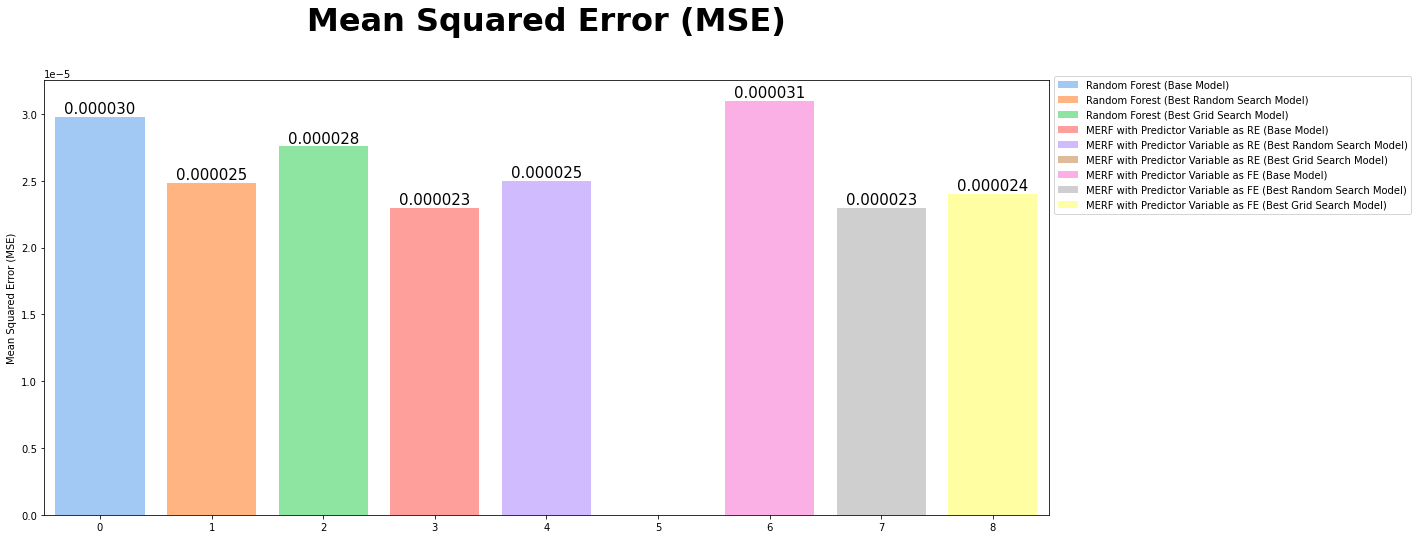

In [111]:
# plot the different models' MSE to compare them
plt.figure(figsize=(18,8))
ax = sns.barplot(x = results.index, y = 'Mean Squared Error (MSE)', data = results,hue = 'Model',
            palette = 'pastel',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'black', errwidth = 1,  
            ci = 'sd',
            dodge = False
            )

ax.legend(bbox_to_anchor=(1, 1.02))
ax.set_title("Mean Squared Error (MSE)",fontdict= { 'fontsize': 32,'fontweight':'bold'}, y = 1.1)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.6f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

